# 二维卷积层

卷积神经网络是含有卷积层的神经网络。本章中介绍的卷积神经网络均使用最常见的二维卷积层。它有高和宽两个空间维度，常用来处理图像数据。

## 二维互相关运算

虽然卷积层得名于卷积运算，但我们通常在卷积层中使用更佳直观的互相关运算。

在⼆维卷积层中，⼀个⼆维输⼊数组和⼀个⼆维核（kernel）数组通过互相关运算输出⼀个⼆维数组。 我们⽤⼀个具体例⼦来解释⼆维互相关运算的含义。如下图，输⼊是⼀个⾼和宽均为3的⼆维数组。我们将该数组的形状记为 或（3，3）。核数组的⾼和宽分别为2。该数组在卷积计算中⼜称卷积核或过滤器（filter）。卷积核窗⼝（⼜称卷积⼝）的形状取决于卷积核的⾼和宽，即 $2 \times2$。下图画蓝的部分为第一个输出元素及其计算所使用的输入和核数组元素：$0 \times 0 +1 \times 1+3 \times 2 +4 \times 3 = 19$

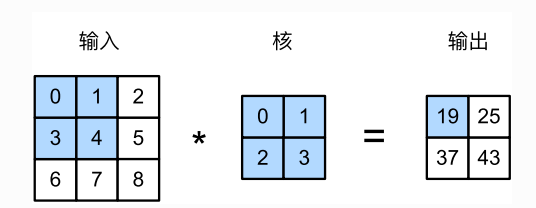

在二维互相关运算中，卷积窗口从输入数组的最左上角开始，按从左往右、从上往下的顺序，依次在输入数组上滑动。当卷积窗口滑动到某一位置时，窗口的输入子数组与核数组按元素相乘并求和，得到输出数组中相应位置的元素。

$$
\begin{align*}
0 \times 0 + 1 \times 1 + 3 \times 2 + 4 \times 3 &= 19, \\
1 \times 0 + 2 \times 1 + 4 \times 2 + 5 \times 3 &= 25, \\
3 \times 0 + 4 \times 1 + 6 \times 2 + 7 \times 3 &= 37, \\
4 \times 0 + 5 \times 1 + 7 \times 2 + 8 \times 3 &= 43.
\end{align*}
$$

下面将上述过程实现在 `corr2d`函数里。它接受输入数组`x`和核数组`k`并输出数组`y`

In [1]:
import torch 
from torch import nn

def corr2d(X,K):
    h,w = K.shape
    y = torch.zeros((X.shape[0]-h+1,X.shape[1]-w+1))
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            y[i,j] = (X[i:i+h,j:j+w]*K).sum()
    return y

In [2]:
X = torch.tensor([[0,1,2],[3,4,5],[6,7,8]])
K = torch.tensor([[0,1],[2,3]])
corr2d(X,K)

tensor([[19., 25.],
        [37., 43.]])

## 二维卷积层

二维卷积层将输入和卷积核做互相关运算，并加上一个标量偏差来得到输出。卷积层的模型参数包括了卷积核和标量偏差。在训练模型的时候，通常我们先对卷积核随机初始化，然后不断迭代卷积核和偏差

下面基于`corr2d`函数来实现一个自定义的二维卷积层。在构造函数`__init__`里，我们声明`weight`和`bias`这两个模型参数。`weight`即卷积核。前向计算`forward`则是直接调用`corr2d`函数再加上偏差，偏差相当于前文中的偏置项

In [16]:
class conv2D(nn.Module):
    def __init__(self,kernel_size):
        super(conv2D,self).__init__()
        self.weight = nn.Parameter(torch.randn(kernel_size))
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self,X):
        return corr2d(X,self.weight)+self.bias

卷积窗口形状为 $p \times q$ 的卷积层称为 $p \times q$ 卷积层。同样 $p \times q$ 卷积或 $p \times q$ 卷积核说明卷积核的高和宽分别为 $p$ 和 $q$

## 图像中物体边缘检测

下面看一下卷积层的简单应用：检测图像中物体的边缘，即找到像素变化的位置。首先我们构造一张 $6 \times 8$ 的图像（即⾼和宽分别为6像素和8像素的图像）。它的中间四列为黑（0），其余为白（1）。

In [17]:
X = torch.ones(6,8)
X[:,2:6]=0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

然后构造一个高和宽分别为1和2的卷积核`K`。当它与输入做互相关运算时，如果横向相邻元素相同，输出为0；否则输出为非0

In [18]:
K = torch.tensor([[1,-1]])

In [19]:
y = corr2d(X,K)
y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

## 通过数据学习核数组

最后来看一个例子，它使用物体边缘检测中的输入数据`X`和输出数据`y`来学习我们构造的核数组`K`。我们首先构造一个卷积层，其卷积核将被初始化为随机数组。接下来在每一次迭代中，我们使用平方误差来比较`y`核卷积层的输出，然后计算梯度来更新权重

In [20]:
# 构造一个核数组形状是（1，2）的二维卷积层
conv2d = conv2D(kernel_size=(1,2)) 

step = 20
lr = 0.01
for i in range(step):
    y_hat = conv2d(X)
    l = ((y_hat-y)**2).sum()
    l.backward()

    #梯度下降
    conv2d.weight.data -= lr * conv2d.weight.grad
    conv2d.bias.data -= lr * conv2d.bias.grad

    #梯度清0
    conv2d.weight.grad.fill_(0)
    conv2d.bias.grad.fill_(0)
    if (i+1)%5 == 0:
        print('Step %d, loss %.3f' % (i + 1, l.item()))

Step 5, loss 6.806
Step 10, loss 1.376
Step 15, loss 0.325
Step 20, loss 0.084


可以看到，20次迭代后误差已经降到了一个比较小的值。现在来看一下学习到的卷积核的参数。

In [21]:
print("weight: ", conv2d.weight.data)
print("bias: ", conv2d.bias.data)

weight:  tensor([[ 0.9189, -0.9376]])
bias:  tensor([0.0104])


可以看到，学到的卷积核的权重参数与我们之前定义的核数组`K`较接近，而偏置参数接近0

## 互相关运算和卷积运算

实际上，卷积运算与互相关运算类似。为了得到卷积运算的输出，我们只需将核数组左右翻转并上下翻转，再与输入数组做互相关运算。可见，卷积运算和互相关运算虽然类似，但如果它们使用相同的核数组，对于同一个输入，输出往往并不相同。上文的都是互相关运算，后文提到的卷积运算均指互相关运算。

## 特征图和感受野

二维卷积层输出的二维数组可以看作是输入在空间维度上某一级的表征，也叫特征图。影响元素 $x$ 的前向计算的所有可能输入区域叫做 $x$ 的感受野。

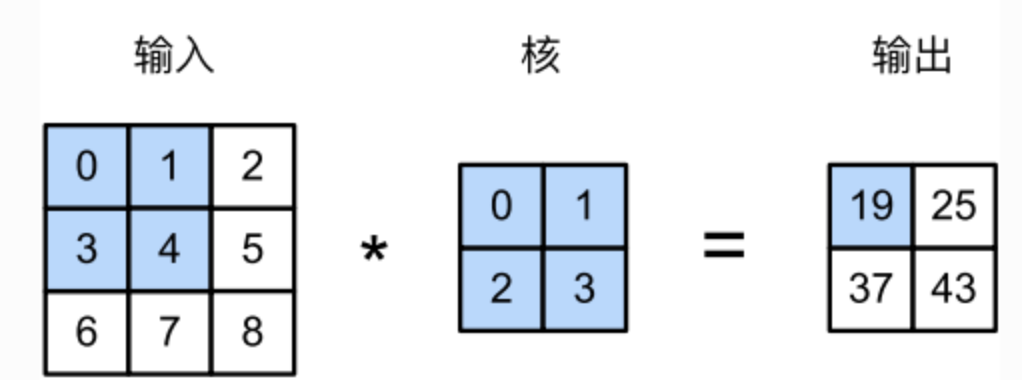

依旧以上图为例，输入中阴影部分的四个元素是输出中阴影部分元素的感受野。我们将图中的输出记为 $y$，并考虑一个更深的卷积神经网络：将 $y$ 与另一个形状为 $2\times 2$ 的核数组做互相关运算，输出单个元素 $z$。那么 $z$ 在 $y$ 上的感受野包括 $y$ 的全部四个元素，在输入上的感受野包括其中全部9个元素。可见我们可以通过更深的卷积神经网络使特征图中单个元素的感受野变得更加广阔，从而捕捉输入上更大尺寸的特征。

我们常使用元素一词来描述数组或矩阵中的成员。在神经网络的术语中，这些元素也称为单元。

## 小结

二维卷积层的核心计算是二维互相关运算。在最简单的形势下，它对二维输入数据和卷积核做互相关运算然后加上偏差。

我们可以设计卷积核来检测图像中的边缘。

我们可以通过数据来学习卷积核。

# 填充和步幅

在上文的例子中，我们使用高和宽都是3的输入和高和宽都是2的卷积核得到高和宽为2的输出。一般来说，假设输入形状为 $n_k \times n_w$，卷积核窗口形状是 $k_k \times k_w$，那么输出形状将会是

$$
(n_k -k_k +1) \times (n_w - k_w +1)
$$

所以卷积层的输出形状有输入形状和卷积核窗口形状决定。

这里介绍卷积层的两个超参数，即填充和步幅。它们可以对给定形状的输入和卷积核改变输出形状

## 填充

填充是指在输出高和宽的两侧填充元素（通常是0元素）。

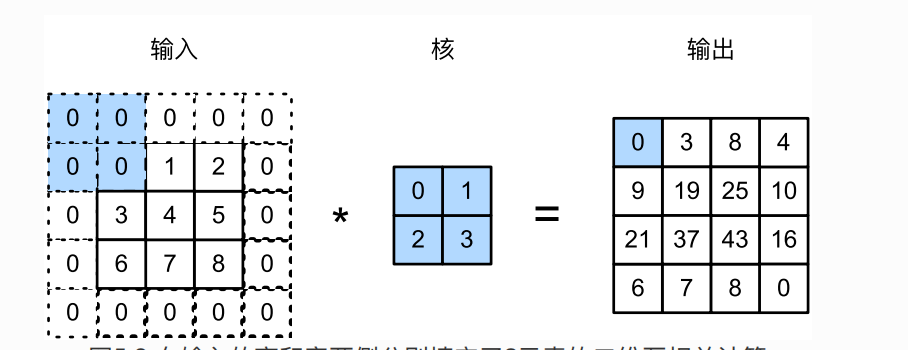

上图中我们在输入高和宽的两侧分别添加了值为0的元素，使得输入高和宽从3变成了5，并导致输出高和宽由2变成了4.

一般来说，如果在高的两侧一共填充了 $p_k$ 行，在宽的两侧一共填充了 $p_w$ 列，那么输出形状将会是

$$
(n_k-k_k+p_k+1) \times (n_w - k_w +p_w+1)
$$

也就是说，输出的高和宽会分别增加 $p_k$ 和 $p_w$。

在很多情况下，我们会设置 $p_h = k_h-1$ 和 $p_w = k_w -1$ 来使输入和输出具有相同的高和宽。这样会方便在构造网络时推测每个层的输出形状。假设这里 $k_h$ 是奇数，我们会在高的两侧分别填充 $p_k/2$ 行。

卷积神经⽹络经常使⽤奇数⾼宽的卷积核，如1、3、5和7，所以两端上的填充个数相等。对任意的⼆维数组 `X` ，设它的第 `i` ⾏第 `j` 列的元素为 `X[i,j]` 。当两端上的填充个数相等，并使输⼊和输出具有相同的⾼和宽时，我们就知道输出 `Y[i,j]` 是由输⼊以 `X[i,j]` 为中⼼的窗⼝同卷积核进⾏互相关计算得到的。

下面的例子里我们创建了一个高和宽为3的二维卷积层，然后设输入高和宽两侧填充数分别为1。给定一个高和宽为8的输入，我们发现输出的高和宽也是8

In [22]:
import torch
from torch import nn

def comp_conv2d(conv2d,X):
    X = X.view((1,1)+X.shape) # 若 X 是形状为 (5, 5) 的二维张量（5x5 像素），转换后形状为 (1, 1, 5, 5)。 添加批量和通道数

    y = conv2d(X)
    return y.view(y.shape[2:]) # 不输出批量和通道数

# 注意这⾥是两侧分别填充1⾏或列，所以在两侧⼀共填充2⾏或列
conv2d = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,padding=1) # padding 表示填充； in_channels 表示输入数据的通道数：颜色；out_channels 表示输出数据的通道数

X = torch.rand(8,8)
comp_conv2d(conv2d,X).shape

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


torch.Size([8, 8])

当卷积核的高和宽不同时，我们也可以通过设置高和宽上不同的填充数使输出和输入具有相同的高和宽

In [23]:
# 使用高为5、宽为3的卷积核。在高和宽两侧的填充数分别为2和1

conv2d = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=(5,3),padding=(2,1))
comp_conv2d(conv2d,X).shape

torch.Size([8, 8])

## 步幅

卷积窗口从输入数组最左上方开始按从左往右、从上往下的顺序，一次在输入数组上滑动。我们将每次滑动的行数和列数称为步幅。

目前的例子里，在高和宽两个方向上的步幅均为1。我们也可以使用更大步幅。

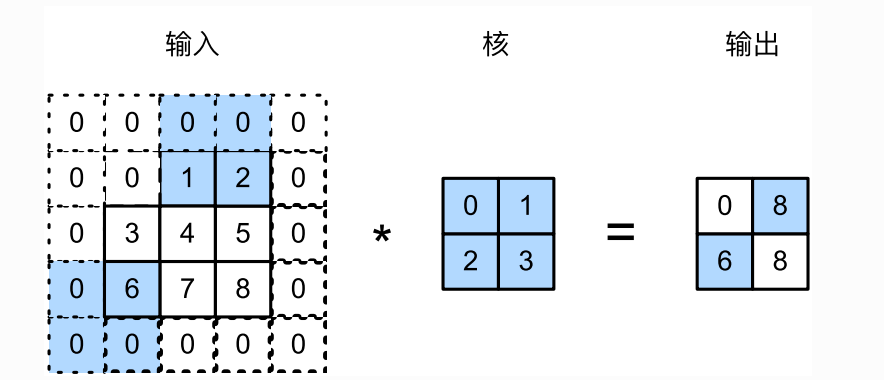

上图展示了在高上步幅为3，在宽上步幅为2的二维互相关运算。可以看到，输出第一列第二个元素时，卷积窗口向下滑动了3、向右滑动了2列。当卷积窗口在输入上再向右滑动2列时，由于输入的元素无法填满窗口，无结果输出。

一般来说，当高上步幅为 $s_h$，宽上步幅为 $s_w$ 时，输出形状为 $\lfloor (n_h - k_h + p_h + s_h)/s_h \rfloor \times \lfloor (n_w - k_w + p_w + s_w)/s_w \rfloor$。

如果设置 $p_h = k_h - 1$ 和 $p_w = k_w - 1$，那么输出形状将简化为 $\lfloor (n_h + s_h - 1)/s_h \rfloor \times \lfloor (n_w + s_w - 1)/s_w \rfloor$。更进一步，如果输入的高和宽能分别被高和宽上的步幅整除，那么输出形状将是 $(n_h / s_h) \times (n_w / s_w)$。

下面令高和宽上的步幅均为2，从而使输入的高和宽减半

In [12]:
conv2d = nn.Conv2d(1,1,kernel_size=3,padding=1,stride=2)
comp_conv2d(conv2d,X).shape

torch.Size([4, 4])

In [13]:
conv2d = nn.Conv2d(1,1,kernel_size=(3,5),padding=(0,1),stride=(3,4))
comp_conv2d(conv2d,X).shape

torch.Size([2, 2])

为了表述简洁，当输入的高和宽两侧的填充数分别为 $p_h$ 和 $p_w$ 时，我们称填充为 $(p_h, p_w)$。特别地，当 $p_h = p_w = p$ 时，填充为 $p$。当在高和宽上的步幅分别为 $s_h$ 和 $s_w$ 时，我们称步幅为 $(s_h, s_w)$。特别地，当 $s_h = s_w = s$ 时，步幅为 $s$。在默认情况下，填充为0，步幅为1。

## 小结

填充可以增加输出的高和宽，这常用来使输出和输入具有相同的高和宽

步幅可以减小输出的高和宽，例如输出的高和宽仅为输入的高和宽的1/n

# 多输入通道和多输出通道

前文用到的输入和输出都是二维数组，但真实数据的维度通常更高。例如，彩色图像在高和宽2个维度外还有RGB（红绿蓝）3个颜色通道。假设彩色图像的高和宽分别为 $h$ 和 $w$，那么它可以表示为一个 $3 \times h \times w$ 的多维数组。我们将大小为3的这一维称为通道维。

## 多输入通道

当输入数据含多个通道时，我们需要构造一个输入通道数和输入数据的通道数相同的卷积核，从而能够与含多通道的输入数据做互相关运算。假设输入数据的通道数为 $c_i$，那么卷积核的输入通道数同样为 $c_i$。设卷积核窗口形状为 $k_k \times k_w$。当 $c_i = 1$ 时，我们知道卷积核只包含一个形状为 $k_h \times h_w$ 的二维数组。当 $c_i >1$ 时，我们将会为每个输入通道各分配一个形状为 $k_h \times k_w$ 的核数组。把这 $c_i$ 个数组在输入通道维上连结，即得到一个形状为 $c_i \times k_k \times k_w$ 的卷积核。由于输入和卷积核各有 $c_i$ 个通道，我们可以在各个通道上对输入的二维数组和卷积核的二维核数组做互相关运算，再将这 $c_i$ 个互相关运算的二维输出按通道相加，得到一个二维数组。这就是含多个通道的输入数据与多输入通道的卷积核做二维互相关运算的输出。

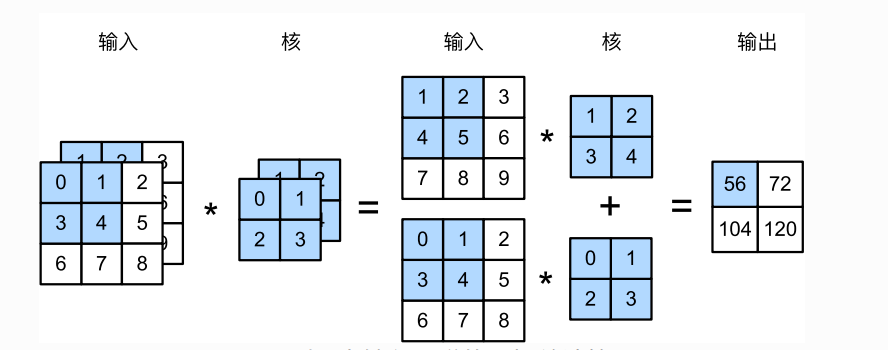

上图展示了含2个输入通道的二维狐仙观计算的例子。在每个通道上，⼆维输⼊数组与⼆维核数组做互相关运算，再按通道相加即得到输出。

接下来我们实现含多输入通道的互相关运算。我们只需要对每个通道做互相关运算，然后通过 `add_n` 函数来进行累加。

In [14]:
import torch
from torch import nn

def corr2d(X,K):
    h,w = K.shape
    y = torch.zeros((X.shape[0]-h+1,X.shape[1]-w+1))
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            y[i,j] = (X[i:i+h,j:j+w]*K).sum()
    return y

def corr2d_muti_in(X,K):
    res = corr2d(X[0,:,:],K[0,:,:])
    for i in range(1,X.shape[0]):
        res += corr2d(X[i,:,:],K[i,:,:])
    return res

In [15]:
X = torch.tensor([[[0, 1, 2], [3, 4, 5], [6, 7, 8]],[[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
K = torch.tensor([[[0, 1], [2, 3]], [[1, 2], [3, 4]]])

corr2d_muti_in(X,K)

tensor([[ 56.,  72.],
        [104., 120.]])

## 多输出通道

当输入通道有多个时，因为我们对各个通道的结果做了累加，所以不论输入通道数为多少，输出通道数总是1。设卷积核输入通道数和输出通道数分别为 $c_i$ 和 $c_o$，高和宽分别为 $k_h$ 和 $k_w$。如果希望得到含多个通道的输出，我们可以为每个输出通道分别创建形状为 $c_i \times k_h \times k_w$ 的核数组，一共有 $c_o$ 个。将它们在输出通道维上连接，卷积核的形状即 $c_o \times c_i \times k_h \times k_w$。在做互相关时，每个输出通道上的结果由卷积核在该输出通道上的核数组与整个输入数组计算而来。

实现一个3通道的输出

In [16]:
def corr2d_muti_in_out(X,K):
    return torch.stack([corr2d_muti_in(X,k) for k in K])

In [17]:
# 解释 torch.stack
K = torch.stack([K,K+1,K+2])
K.shape

torch.Size([3, 2, 2, 2])

In [18]:
corr2d_muti_in_out(X,K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

## 1 X 1 卷积层

最后讨论卷积窗口形状为 $1 \times 1$ 的多通道卷积层。我们称之为 $1\times 1$ 卷积层，并将其中的卷积运算称为 $1\times 1$ 卷积。因为使⽤了最⼩窗⼝，$1\times 1$ 卷积失去了卷积层可以识别高和宽维度上相邻元素构成的模式的功能。实际上，$1\times 1$ 卷积的主要计算发生在通道上。

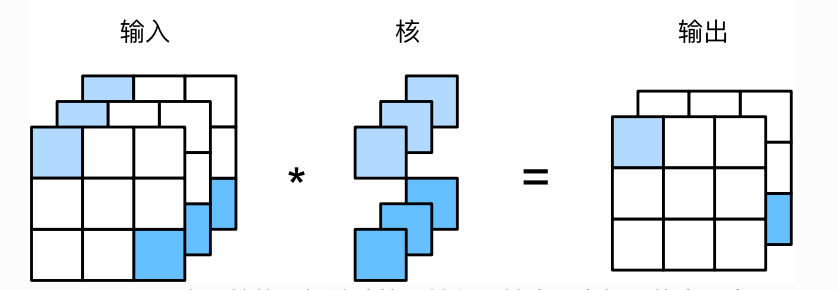

上图展示了输入通道数为3、输出通道数为2的 $1\times 1$ 卷积核的互相关计算。输入核输出具有相同的高和宽。输出中每个元素来自输入中在高和宽上相同位置元素在不同通道之间的按权重相加。假设我们将通道维当作特征维，将高和宽维度上的元素当初数据样本，那么 $1 \times 1$ 卷积层的作用与全连接层等价。

下面我们使用全连接层中的矩阵乘法来实现 $1 \times 1$ 卷积。这里需要在矩阵乘法运算前后，对数据形状做一些调整。

In [19]:
def corr2d_muti_in_out_1x1(X,K):
    c_i,h,w = X.shape
    c_o = K.shape[0]
    X = X.view(c_i,h*w) #将二维平面数组拼接成1维数据
    K = K.view(c_o,c_i) #只保留
    y = torch.mm(K,X)
    return y.view(c_o,h,w) #还原

In [20]:
X = torch.rand(3,3,3)
K = torch.rand(2,3,1,1)

y1 = corr2d_muti_in_out_1x1(X,K)
y2 = corr2d_muti_in_out(X,K)

print(y1)
print(y2)

# 1x1卷积与之前实现的互相关运算函数等价

tensor([[[0.9734, 0.8090, 1.2219],
         [1.3330, 0.3570, 0.4739],
         [0.1537, 0.0816, 1.0955]],

        [[0.7400, 0.7514, 1.3360],
         [1.2739, 0.7230, 0.3945],
         [0.3493, 0.2090, 1.1471]]])
tensor([[[0.9734, 0.8090, 1.2219],
         [1.3330, 0.3570, 0.4739],
         [0.1537, 0.0816, 1.0955]],

        [[0.7400, 0.7514, 1.3360],
         [1.2739, 0.7230, 0.3945],
         [0.3493, 0.2090, 1.1471]]])


## 小结

使用多通道可以拓展卷积的模型参数

假设通道维当作特征维，将高和宽维度上的元素当成数据样本，那么 $1 \times 1$ 卷积层的作用与全连接层等价

$1 \times 1$ 卷积层通常用来调整网络层之间的通道数，并控制模型复杂度。

# 池化层

在二维卷积层里介绍的图像物体边缘检测应用中，我们构造卷积核从而精确地找到了像素变化的位置。设任意而为数据 `X` 的`i` 行`j`列元素维 `X[i,j]`。如果我们构造卷积核输出 `y[i,j]=1` ，那么说明输⼊中 `X[i, j]` 和 `X[i, j+1]` 数值不⼀样。这可能意味着物体边缘通过这两个元素之间。但实际图像⾥，我们感兴趣的物体不会总出现在固定位置：即使我们连续拍摄同⼀个物体也极有可能出现像素位置上的偏移。这会导致同⼀个边缘对应的输出可能出现在卷积输出 `Y` 中的不同位置，进⽽对后⾯的模式识别造成不便。

池化（pooling）层，它的提出是为了缓解卷积层对位置的过度敏感性。

## 二维最大池化层和平均池化层

同卷积层一样，池化层每次输入数据的一个固定形状窗口（又称池化窗口）中的元素计算输出。不同于卷积层里计算输入和核的互相关行，池化层直接计算池化窗口内元素的最大值或平均值。该运算也分别叫做最大池化或平均池化。在二维最大池化中，池化窗口从输入数组的最左上方开始，按从左往右、从上往下的顺序，依次在输入数组上滑动。当池化窗口滑动到某一位置时，窗口中的输入子数组的最大值即输出数组中相应位置的元素。

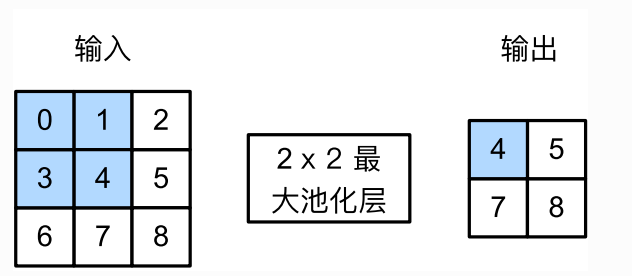

图5.6展示了池化窗口形状为 $2 \times 2$ 的最大池化，阴影部分为第一个输出元素及其计算所使用的输入元素。输出数组的高和宽分别为2，其中的4个元素由取最大值运算 $\text{max}$ 得出：

$$
\max(0,1,3,4) = 4,
$$

$$
\max(1,2,4,5) = 5,
$$

$$
\max(3,4,6,7) = 7,
$$

$$
\max(4,5,7,8) = 8.
$$

二维平均池化的工作原理与二维最大池化类似，但将最大运算符替换成平均运算符。池化窗口形状为 $p \times q$ 的池化层称为 $p \times q$ 池化层，其中的池化运算叫作 $p \times q$ 池化。

回到最开始提到的物体边缘检测的例子。现在我们将卷积层的输出作为 $2 \times 2$ 最大池化的输入。设该卷积层输入是 `X`、池化层输出为`Y`。无论是`X[i,j]`和`X[i,j+1]`值不同，还是`X[i,j+1]`和`X[i,j+2]`不同，池化层输出均有`y[i,j] = 1`。也就是说，使用 $2 \times 2$ 最大池化层时，只要卷积层识别的模式在高和宽上移动不超过一个元素，我们依然可以将它检测出来。

下面把池化层的前向计算实现在代码中。

In [21]:
import torch
from torch import nn

def pool2d(X,pool_size,mode="max"):
    X = X.float()
    p_h,p_w = pool_size
    y = torch.zeros(X.shape[0] - p_h+1,X.shape[1]-p_w+1)
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            if mode =='max':
                y[i,j] = X[i:i+p_h,j:j+p_w].max()
            elif mode == 'avg':
                y[i,j] = X[i:i+p_h,j:j+p_w].mean()
    return y
            

In [22]:
X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
pool2d(X,(2,2))

tensor([[4., 5.],
        [7., 8.]])

In [23]:
# 平均池化

pool2d(X,(2,2),'avg')

tensor([[2., 3.],
        [5., 6.]])

## 填充和步幅

和卷积层一样，池化层也可以在输入的高和宽两侧的填充并调整窗口的移动步幅来改变输出形状。池化层填充和步幅与卷积层填充和步幅的工作机制一样。我们将通过`nn`模块里的二维最大池化层 `maxpool2d`来演示池化层填充和步幅的工作机制。

In [24]:
X = torch.arange(16,dtype=torch.float).view((1,1,4,4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

默认情况下， `MaxPool2d` 实例⾥步幅和池化窗⼝形状相同。下⾯使⽤形状为(3, 3)的池化窗⼝，默认获
得形状为(3, 3)的步幅。

In [25]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

手动指定步幅和填充

In [26]:
pool2d = nn.MaxPool2d(3,padding=1,stride=2) #3表示池化层尺寸
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [28]:
pool2d = nn.MaxPool2d((2,4),padding=(1,2),stride=(2,3))
pool2d(X)

tensor([[[[ 1.,  3.],
          [ 9., 11.],
          [13., 15.]]]])

## 多通道

在处理多通道输⼊数据时，池化层对每个输⼊通道分别池化，⽽不是像卷积层那样将各通道的输⼊按通道相加。这意味着池化层的输出通道数与输⼊通道数相等。下⾯将数组 X 和 X+1 在通道维上连结来构造通道数为2的输⼊

In [29]:
X= torch.cat((X,X+1),dim=1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [30]:
pool2d = nn.MaxPool2d(3,padding=1,stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## 小结

最大池化和平均池化分别取池化窗口中输入元素的最大值和平均值作为输出

池化层的一个主要作用是缓解卷积层对位置的过度敏感性。

可以指定池化层的填充和步幅

池化层的输出通道数和输入通道数相同。

# 卷积神经⽹络（LENET）

在多层感知机里我们构造了一个含单隐藏层的多层感知机模型对Fashion——MNist数据集中的图像进行分类。每章图像高和宽均是28像素。我们将图像中的像素逐行展开，得到长度为784的向量，并输入进全连接层中。然而，这种分类法有一定局限性：
1. 图像在同一列相邻的像素在这个向量中可能相距较远。它们构成的模式可能难以被模型识别
2. 对于大尺寸的输入图像，使用全连接层容易造成模型过大。假设输入是高和宽均为1000像素的彩色图片。即使全连接层的输出个数仍是256，该层的权重参数形状是 $3000000 \times 256$：它占用了大约3GB的内存或显存。这带来过复杂的模型和过高的存储开销。

卷积层尝试解决这两个问题。一方面，卷积层保留输入形状，使图像的像素在高和宽两个方向上的相关性均可能被有效识别；另一方面，卷积层通过滑动窗口将同一卷积核与不同位置的输入重复计算，从而避免参数尺寸过大。

卷积神经网络就是含卷积层的网络，下文揭晓一个早期用来识别手写数字图像的卷积神经网络LeNet。LeNet展示了通过梯度下降训练卷积神经网络可以达到手写数字识别在当时最先进的结果。这个奠基性的工作第一次将卷积神经网络推上舞台，为世人所知。

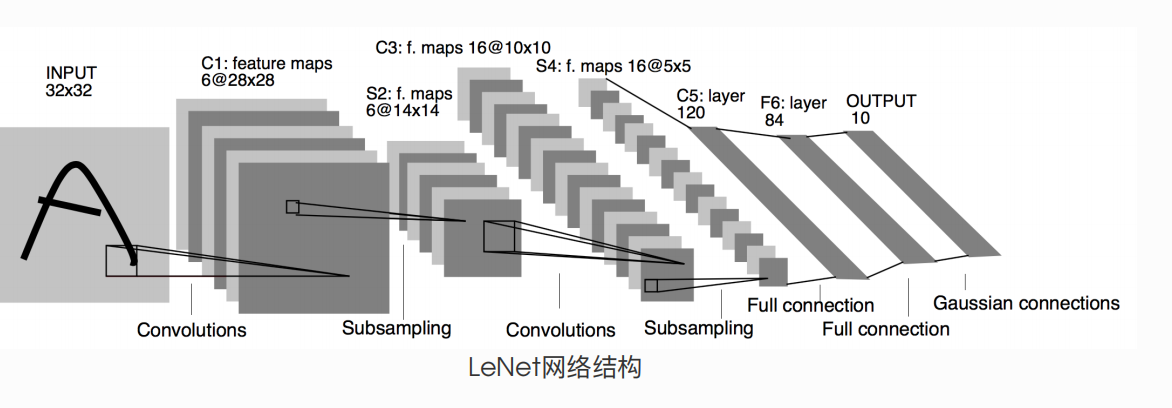

LeNet分为卷积块和全连接层块两个部分。下面分别介绍这两个模块

卷积层块里的基本单位是卷积层后接最大池化层：卷积层用来识别图像里的空间模式，如线性和物体局部，之后的最大池化层则用来降低卷积层对位置的敏感度。卷积层块由两个这样的基本单位重复堆叠构成。在卷积层块中，每个卷积层都使用 $5 \times 5$ 的窗口，并在输出上使用sigmoid激活函数。第一个卷积层的输出通道数位6，第二个卷积层输出通道数则增加到16。因为第二个卷积层比第一个卷积层的输入的高和宽要小，所以增加输出通道使两个卷积层的参数尺寸类似。

卷积层块的两个最大池化层的窗口形状均为 $2 \times 2$，且步幅为2。由于池化窗口与步幅形状相同，池化窗口在输入上每次滑动所覆盖的区域互不重叠。

卷积层块的输出形状为（批量大小，通道，高，宽）。当卷积快的输出传入全连接层块时，全连接层块会将小批量中每个样本变平。也就是说，前连接层的输入形状变成二维，其中第一维时小批量中的样本，第二维是每个样本变平后的向量表示，且向量长度为通道、高和宽的乘积。全连接层块含3个全连接层。它们的输出个数分别是120、84和10，其中10位输出的类别个数。


In [2]:
import torch 
import time
from torch import nn as nn
from torch import optim



In [3]:
device = torch.device('mps')

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [4]:
print(net)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


可以看到，在卷积层块中输⼊的⾼和宽在逐层减⼩。卷积层由于使⽤⾼和宽均为5的卷积核，从⽽将⾼和宽分别减⼩4，⽽池化层则将⾼和宽减半，但通道数则从1增加到16。全连接层则逐层减少输出个数，直到变成图像的类别数10。

## 获取数据核训练数据

下面来实验LeNet模型。仍然以Fashion——MNIST作为训练数据集

In [6]:
import torchvision
import torchvision.transforms as transforms

batch_size =256
mnist_train =torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST',train=True, download=True, transform=transforms.ToTensor())
mnist_test =torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST',train=False, download=True, transform=transforms.ToTensor())
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=4)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=4)

In [7]:
def evaluate_accuracy(data_iter,net,device = 'mps'):
    acc_sum,n = 0.0,0
    with torch.no_grad():
        for X,y in data_iter:
            if isinstance(net,torch.nn.Module):
                net.eval #评估模式，关闭dropout丢包
                acc_sum += (net(X.to(device)).argmax(dim=1)==y.to(device)).float().sum().item()
                net.train() #改回训练模式
            else:
                if('is_training' in net.__code__.co_varnames):
                    acc_sum +=(net(X.to(device),is_training = False).argmax(dim=1)==y).float().sum().item()
                else:
                    acc_sum +=(net(X.to(device)).argmax(dim=1)==y).float().sum().item()
            n+=y.shape[0]
    return acc_sum/n

In [8]:
def train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs):
    net = net.to(device)
    print("training on",device)
    loss = torch.nn.CrossEntropyLoss()
    batch_count =0
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n,start=0.0,0.0,0,time.time()
        for X,y, in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum +=(y_hat.argmax(dim=1)==y).sum().cpu().item()
            n +=y.shape[0]
            batch_count +=1
        test_acc = evaluate_accuracy(test_iter,net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f,time %.1f sec'% (epoch + 1, train_l_sum / batch_count,train_acc_sum / n, test_acc, time.time() - start))

In [9]:
lr, num_epochs = 0.001, 10
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
train_ch5(net, train_iter, test_iter, batch_size, optimizer, device,num_epochs)

training on mps
epoch 1, loss 1.7334, train acc 0.373, test acc 0.601,time 7.6 sec
epoch 2, loss 0.4433, train acc 0.665, test acc 0.706,time 5.8 sec
epoch 3, loss 0.2437, train acc 0.726, test acc 0.739,time 6.1 sec
epoch 4, loss 0.1638, train acc 0.746, test acc 0.748,time 6.0 sec
epoch 5, loss 0.1216, train acc 0.762, test acc 0.765,time 6.1 sec
epoch 6, loss 0.0959, train acc 0.776, test acc 0.770,time 6.1 sec
epoch 7, loss 0.0783, train acc 0.789, test acc 0.792,time 6.1 sec
epoch 8, loss 0.0655, train acc 0.802, test acc 0.796,time 6.2 sec
epoch 9, loss 0.0555, train acc 0.813, test acc 0.806,time 6.2 sec
epoch 10, loss 0.0479, train acc 0.821, test acc 0.811,time 6.3 sec


# 深度卷积神经网络（ALEXNET）

在LeNet提出后，神经网络一度被其他机器学习方法超越，如支持向量机。虽然LeNet可以在早期的小数据集上取得好的成绩，但是在更大的真实数据上的表现不尽如人意。一方面，神经网络计算复杂；另一方面，当年的研究者还没有大量深入研究参数初始化和非凸优化算法的诸多领域，导致复杂的神经网络的训练通常较困难。

上文中学到，神经网络可以直接基于图像的原始像素进行分类。这种称为端到端的方法节省了很多中间步骤。

由计算机视觉流程可知，计算机视觉流程中真正重要的是数据和特征。使用较干净的数据集和较有效的特征比机器学习模型的选择对图像分类结果的影响更大。

## 学习特征表示

既然特征如此重要，它该如何表示呢。有两种说法：一种是手工设计；另一种是由学习得来

## ALEXNET

AleNet使用了8层卷积神经网络，并以很大的优势赢得了imageNet2012图像识别挑战赛。它首次证明了学习到的特征可以超越手工设计的特征，从而打破计算机视觉研究的前状

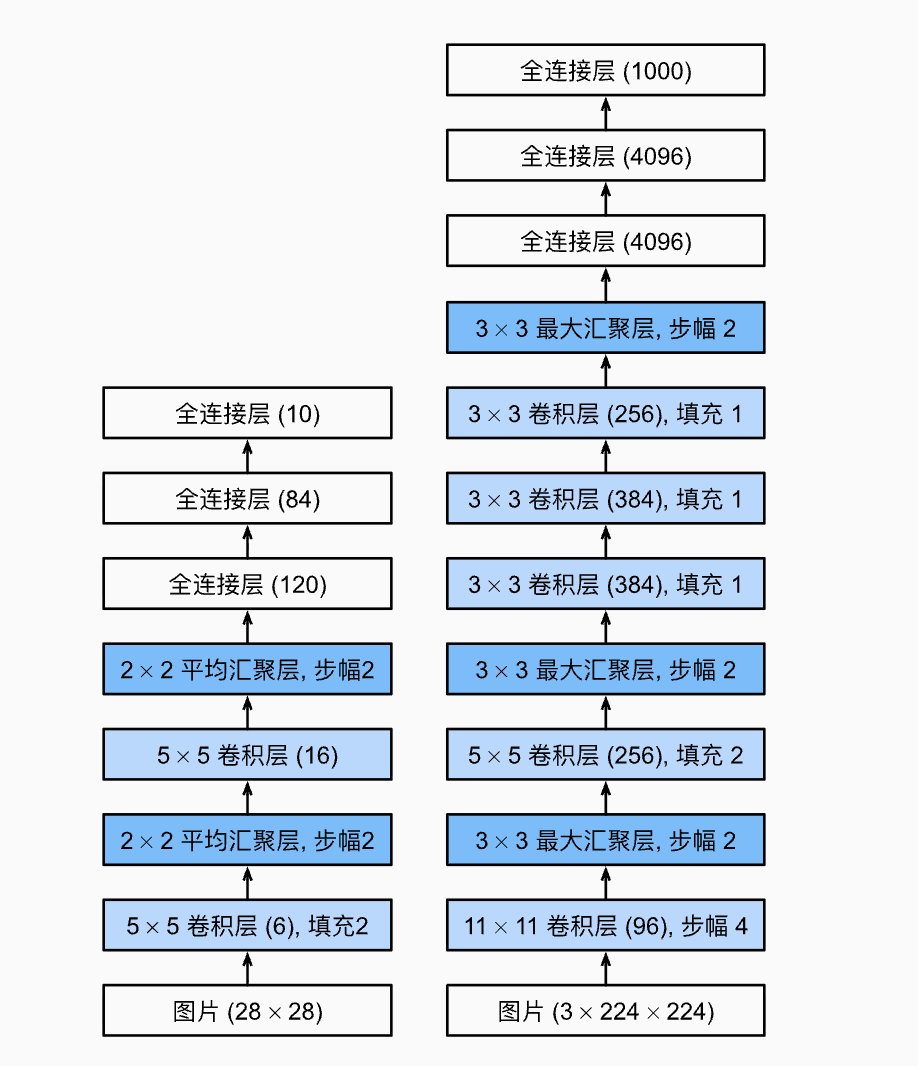

与较小的LeNet相比，AleNet包含8层变换，其中5层卷积核2层全连接隐藏层，以及1个全连接输出层。

AlexNet第一层中的卷积窗口形状是 $11 \times 11$。因为ImageNet中绝大多数图像的高和宽均比MNIST图像的高和宽大10倍以上，ImageNet图像的物体占用更多的像素，所以需要更大的卷积窗口来捕获物体。第二层中的卷积窗口形状减小到 $5 \times 5$，之后全采用 $3 \times 3$。此外，第一、第二和第五个卷积层之后都使用了窗口形状为 $3 \times 3$、步幅为2的最大池化层。而且，AlexNet使用的卷积通道数也大于LeNet中的卷积通道数数十倍。

AlexNet将sigmoid激活函数改成了更加简单的ReLU激活函数。⼀⽅⾯，ReLU激活函数的计算更简单，例如它并没有sigmoid激活函数中的求幂运算。另⼀⽅⾯，ReLU激活函数在不同的参数初始化⽅法下使模型更容易训练。这是由于当sigmoid激活函数输出极接近0或1时，这些区域的梯度⼏乎为0，从⽽造成反向传播⽆法继续更新部分模型参数；⽽ReLU激活函数在正区间的梯度恒为1。因此，若模型参数初始化不当，sigmoid函数可能在正区间得到⼏乎为0的梯度，从⽽令模型⽆法得到有效训练。

AlexNet通过丢弃法来控制全连接层的模型复杂度。⽽LeNet并没有使⽤丢弃法。

AlexNet引⼊了⼤量的图像增⼴，如翻转、裁剪和颜⾊变化，从⽽进⼀步扩⼤数据集来缓解过拟合。我们将在后⾯（图像增⼴）详细介绍这种⽅法。

In [20]:
import time
import torch
from torch import nn,optim
import torchvision
device = torch.device('mps')


class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,96,11,4),
            nn.ReLU(),
            nn.MaxPool2d(3,2),
            nn.Conv2d(96,256,5,1,2),
            nn.ReLU(),
            nn.MaxPool2d(3,2),
            nn.Conv2d(256,384,3,1,1),
            nn.ReLU(),
            nn.Conv2d(384,384,3,1,1),
            nn.ReLU(),
            nn.Conv2d(384,256,3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(3,2)
        )

        self.fc = nn.Sequential(
            nn.Linear(256*5*5,4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096,4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096,10),
        )

    def forward(self,img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0],-1))
        return output


In [21]:
net = AlexNet()
print(net)

AlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (

## 读取数据

虽然论文中AlexNet使用imageNet数据集，但因为imageNet数据集训练时间较长，我们仍用钱吗的Fashion- MNIST数据集来掩饰AlexNet。读取数据时我们额外做了一步将图像高和宽扩大到AlexNet使用的图像高和宽224.这个可以通过`torchvision.transforms.Resize`实例来实现。也就是说，我们在`ToTensor`实例前使用`Resize`实例，然后使用`Compose`实例来将这两个变换串联以方便调用

In [10]:
def load_data_fashion_mnist(batch_size,resize = None,root='~/Datasets/FashionMNIST'):
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    transform = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=root,train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root,train=False, download=True, transform=transform)
    train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True, num_workers=4)
    test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False, num_workers=4)
    return train_iter,test_iter

batch_size=256
train_iter,test_iter= load_data_fashion_mnist(batch_size,resize=224)

In [11]:
lr,num_epochs = 0.001,5
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs)

training on mps


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (256x46656 and 400x120)

## 小结

AlexNet跟LeNet结构类似，但是用了更多的卷积层核更大的参数空间来拟合大规模数据集imageNet。它是浅层神经网络和深度神经网络的分界线


# 使用重复元素的网络（VGG）

AlexNet在LeNet基础上增加了3个卷积层，但AlexNet作者对它们的卷积窗口、输出通道数和构造顺序均做了大量的调整。虽然AlexNet指明了深度卷积神经可以取得出色的结果，但并没有提供简单的规则以指导后来的研究者如何设计新的网络。

这里介绍VGG，它提出了可以通过重复使用简单的基础块来构建深度模型的思路

## VGG 块

VGG块的组成规则是：连续使用数个相同的填充为1、窗口形状为 $3 \times 3$ 的卷积层后接上一个步幅为2、窗口形状为 $2 \times 2$ 的最大池化层。卷积层保持输入的高和宽不变，而池化层则对其减半。我们使用 `vgg_block` 函数来实现这个基础的 VGG块，它可以指定卷积层的数量和输入输出通道数。

In [12]:
import torch
import time
from torch import nn,optim

device = torch.device('mps')
def vgg_block(num_convs,in_channels,out_channels):
    blk = []
    for i in range(num_convs):
        if i == 0:
            blk.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))
        else:
            blk.append(nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1))
        blk.append(nn.ReLU())
    blk.append(nn.MaxPool2d(kernel_size=2,stride=2))

    return nn.Sequential(*blk)

## VGG网络

和AlexNet和LeNet一样，VGG网络由卷积层模块后接全连接层模块构成。卷积层模块串联数个`vgg_block`，其超参数由变量`conv_arch`定义。该变量制定了每个VGG块里卷积层个数和输入输出通道数。全连接模块则跟AlexNet中的一样

形状构造一个VGG网络。它有5个卷积块，前2个使用单卷积层，而后三个使用双卷积层。第一块的输入输出通道分别是1和64，之后每次对输出通道数翻倍，知道变为512.因为这个网络使用了8个卷积层和3个全连接层，所以经常被称为VGG-11

In [13]:
conv_arch = ((1,1,64),(1,64,128),(2,128,256),(2,256,512),(2,512,512))
fc_features = 512*7*7
fc_hidden_units = 4096

In [14]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1) # 将X 转化成 batch *1*28*28

In [15]:
def vgg(conv_arch,fc_features,fc_hidden_units=4096):
    net = nn.Sequential()
    for i ,(num_convs,in_channels,out_channels) in enumerate(conv_arch):
        net.add_module('vgg_block_' +str(i+1),vgg_block(num_convs,in_channels,out_channels))
    net.add_module('fc',nn.Sequential(
        FlattenLayer(),
        nn.Linear(fc_features,fc_hidden_units),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(fc_hidden_units,fc_hidden_units),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(fc_hidden_units,10)
    ))
    return net


In [16]:
net = vgg(conv_arch,fc_features,fc_hidden_units)
X = torch.rand(1,1,224,224)

# named_children获取⼀级⼦模块及其名字(named_modules会返回所有⼦模块,包括⼦模块的⼦模块)
for name,blk in net.named_children():
    X = blk(X)
    print(name,'output shape:',X.shape)

vgg_block_1 output shape: torch.Size([1, 64, 112, 112])
vgg_block_2 output shape: torch.Size([1, 128, 56, 56])
vgg_block_3 output shape: torch.Size([1, 256, 28, 28])
vgg_block_4 output shape: torch.Size([1, 512, 14, 14])
vgg_block_5 output shape: torch.Size([1, 512, 7, 7])
fc output shape: torch.Size([1, 10])


可以看到，每次讲输入的高和宽减半，直到最终高和宽变成7后传入全连接层。与此同时，输出通道数每次翻倍，直到变成512.因为每个卷积层的窗口大小一样，所以每层的模型参数尺寸和计算复杂度与输入高、输入宽、输入通道数和输出通道数的乘积成正比。VGG这种高和宽减半以及通道翻倍的设计使得多数卷积层都有相同的模型参数尺寸和计算复杂度。

## 获取数据和训练模型

因为VGG-11计算上⽐AlexNet更加复杂，出于测试的⽬的我们构造⼀个通道数更⼩，或者说更窄的⽹络在Fashion-MNIST数据集上进⾏训练。

In [17]:
ratio = 8
small_conv_arch=[(1, 1, 64//ratio), (1, 64//ratio, 128//ratio),(2, 128//ratio, 256//ratio),(2, 256//ratio, 512//ratio), (2, 512//ratio,512//ratio)]
net = vgg(small_conv_arch,fc_features//ratio,fc_hidden_units//ratio)
print(net)

Sequential(
  (vgg_block_1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
import torchvision
import torchvision.transforms as transforms

def load_data_fashion_mnist(batch_size,resize = None,root='~/Datasets/FashionMNIST'):
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    transform = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=root,train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root,train=False, download=True, transform=transform)
    train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True, num_workers=4)
    test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False, num_workers=4)
    return train_iter,test_iter

batch_size=256
train_iter,test_iter= load_data_fashion_mnist(batch_size,resize=224)



In [19]:
lr,num_epochs = 0.001,5
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs)

training on mps
epoch 1, loss 0.7837, train acc 0.700, test acc 0.836,time 119.4 sec
epoch 2, loss 0.1803, train acc 0.869, test acc 0.864,time 144.7 sec
epoch 3, loss 0.1016, train acc 0.891, test acc 0.882,time 129.3 sec
epoch 4, loss 0.0683, train acc 0.900, test acc 0.894,time 131.1 sec
epoch 5, loss 0.0493, train acc 0.911, test acc 0.900,time 137.1 sec


# 网络中的网络（NIN）

前文介绍的LeNet、AlexNet和VGG在设计上的共同之处是：先以由卷积层构成的模块充分抽取时间特征，再以由全连接层构成的模块来输出分类结果。

其中，AlexNet和VGG对LeNet的改进主要在于如何对这两个模块加宽（增加通道数）和加深。这里介绍网络中的网络NIN。它提出了另一种思路，即串联多个由卷积层和全连接层构成的小网络来构建一个深度网络。

## NIN块

我们知道，卷积层的输入和输出通常是四维数据（样本，通道，高，块），而全连接层的输入和输出通常是二维数组（样本和特征）。如果想在全连接层再接上卷积层，则需要将全连接层的输出变换为四维。回顾之前的 $1 \times 1$ 卷积层。它可以堪成全连接层，其中空间维度（高和宽）上的每个元素相当于样本，通道相当于特征。因此NI呢使用 $1 \times 1$卷积层来替代全连接层，从而使空间信息能够自然传递到后面的层中去。下图对比了NIN同AlexNet和VGG等网络在结构上的主要区别。

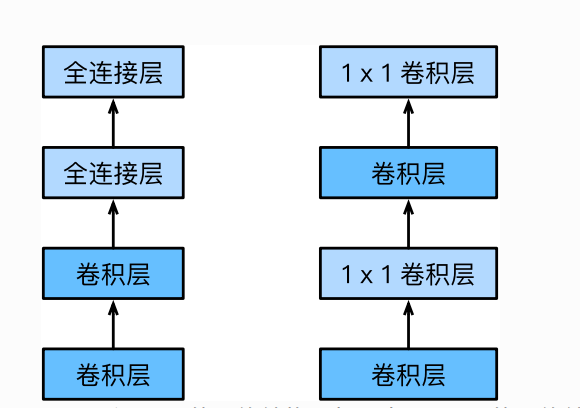

NIN块是NIN中的基础块。它由一个卷积层加两个充当全连接层的 $1 \times 1$ 卷积层串联而成。其中第一个卷积层的超参数可以自行设置，而第二和第三个卷积层的超参数一般是固定的。

In [12]:
import time
import torch
from torch import nn,optim

device = torch.device('mps')
def nin_block(in_channels,out_channels,kernel_size,stride,padding):
    blk = nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),
                        nn.ReLU(),
                        nn.Conv2d(out_channels,out_channels,kernel_size=1),
                        nn.ReLU(),
                        nn.Conv2d(out_channels,out_channels,kernel_size=1,),
                        nn.ReLU())
    return blk

## NIN 模型

NIN是在AlexNet问世不久后提出的。它们的卷积层设定由类似之处。NIN使用卷积窗口形状分别为 $11 \times 11$、$5 \times 5$ 和 $3 \times 3$ 的卷积层，相应的输出通道数也和AlexNet中的一致。每个NIN块后接一个步幅为2、窗口形状为 $3 \times 3$ 的最大池化层。

除使用NIN块以外，NIN还有一个设计与AlexNet显著不同：NIN去掉了AlexNet最后三个全连接层，取而代之地，NIN使用了输出通道等于标签类别输的NIN块，然后使用全局平均池化层对每个通道中所有元素取平均并直接用于分类。这里的全局平均池化层即窗口形状等于输入空间维形状的平均池化层。NIN的这个设计的好处是可显著减小模型参数尺寸，从而缓解过拟合。然后有时会造成获得有效模型的训练时间的增加。

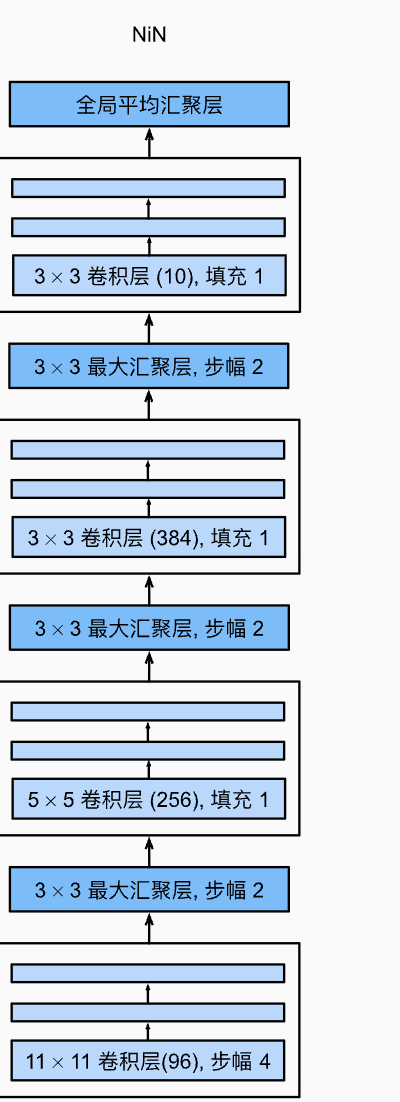

In [13]:
net = nn.Sequential(nin_block(1,96,kernel_size=11,stride=4,padding=0),
        nn.MaxPool2d(3,stride=2),
        nin_block(96,256,kernel_size=5,stride=1,padding=2),
        nn.MaxPool2d(3,stride=2),
        nin_block(256,384,kernel_size=3,stride=1,padding=1),
        nn.MaxPool2d(3,stride=2),
        nn.Dropout(0.5),
        nin_block(384,10,kernel_size=3,stride=1,padding=1),
        nn.AdaptiveAvgPool2d((1,1)), # 每个通道的每个像素点取平均值
        nn.Flatten() #展开
        )

In [14]:
X = torch.rand(1, 1, 224, 224)
for name, blk in net.named_children():
    X = blk(X)
    print(name, 'output shape: ', X.shape)

0 output shape:  torch.Size([1, 96, 54, 54])
1 output shape:  torch.Size([1, 96, 26, 26])
2 output shape:  torch.Size([1, 256, 26, 26])
3 output shape:  torch.Size([1, 256, 12, 12])
4 output shape:  torch.Size([1, 384, 12, 12])
5 output shape:  torch.Size([1, 384, 5, 5])
6 output shape:  torch.Size([1, 384, 5, 5])
7 output shape:  torch.Size([1, 10, 5, 5])
8 output shape:  torch.Size([1, 10, 1, 1])
9 output shape:  torch.Size([1, 10])


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


## 获取数据训练模型

依然使用Fashion-MNist 数据集来训练模型。NIN的训练与AlexNet和VGG的类似，但这里使用的学习率更大

In [15]:
batch_size = 256
def load_data_fashion_mnist(batch_size,resize = None,root='~/Datasets/FashionMNIST'):
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    transform = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=root,train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root,train=False, download=True, transform=transform)
    train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True, num_workers=4)
    test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False, num_workers=4)
    return train_iter,test_iter
train_iter,test_iter = load_data_fashion_mnist(batch_size,resize=224)

lr,num_epochs = 0.002,5
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs)



training on mps
epoch 1, loss 1.5007, train acc 0.455, test acc 0.667,time 319.9 sec
epoch 2, loss 0.3999, train acc 0.702, test acc 0.722,time 397.2 sec
epoch 3, loss 0.2372, train acc 0.732, test acc 0.738,time 406.4 sec
epoch 4, loss 0.1637, train acc 0.749, test acc 0.754,time 429.1 sec
epoch 5, loss 0.1245, train acc 0.761, test acc 0.729,time 449.9 sec


# 含并行连结的网络（GOOGLENET）

GoogleNet吸收了NIN中网络串联网络的思想，并在此基础上做了很大改进。

## INCEPTION块

GoogleNet中的基础卷积块叫做inception块，得名于电影《盗梦空间》（inception）。与上文介绍的NIN块相比，这个基础块在结构上更加复杂。

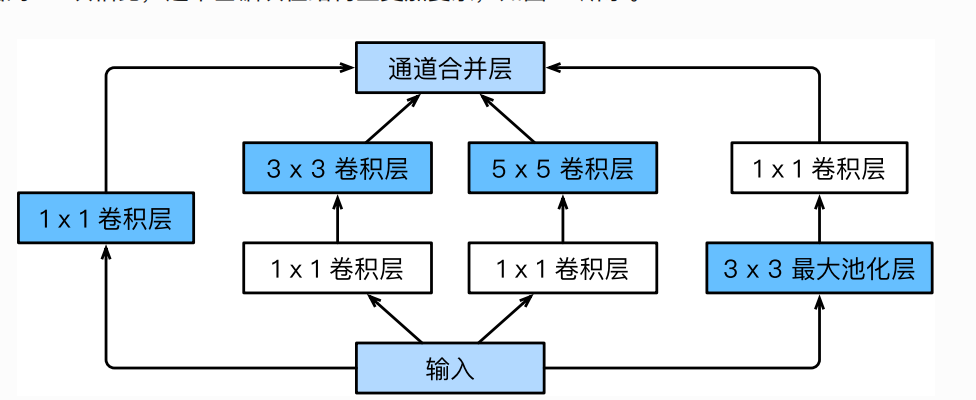

由上图可知，inception块里有4条并行的路线，前三条路线使用的都是卷积层来抽取不同空间尺寸下的信息，其中中间2个路线会对输入先做 $1 \times 1$ 卷积来减少输入通道，以降低模型复杂度。第四条路线则使用 $3 \times 3$ 最大池化层，后接 $1 \times 1$ 卷积层来改变通道数。4条路线都是用了合适的填充来使输入和输入的高和宽一致。最后我们将每条路线的输入在通道维上连结，并输入接下来的层中去。

inception块中可以自定义的超参数是每个层的输出通道数，我们以此来控制模型复杂度。

In [17]:
import time 
import torch
from torch import nn,optim
import torch.nn.functional as F
device = torch.device('mps')

In [18]:
class Inception(nn.Module):
    def __init__(self,in_c,c1,c2,c3,c4):
        super(Inception,self).__init__()
        self.p1_1 = nn.Conv2d(in_c,c1,kernel_size=1)
        self.p2_1 = nn.Conv2d(in_c,c2[0],kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1)
        self.p3_1 = nn.Conv2d(in_c,c3[0],kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0],c3[1],kernel_size=5,padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.p4_2 = nn.Conv2d(in_c,c4,kernel_size=1)

    def forward(self,X):
        p1 = F.relu(self.p1_1(X))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(X))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(X))))        
        p4 = F.relu(self.p4_2(F.relu(self.p4_1(X))))
        
        return torch.cat((p1,p2,p3,p4),dim=1)

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
                   )